Offensive Win Shares = ((Points Produced) - 0.92(League Points Per Possession)*(Offensive Possessions))/(0.32*(League Points Per Game)*((Team Pace)/(League Pace)))

Defensive Win Shares = ((Player Minutes Played/Team Minutes Played)*(Team Defensive Possessions)*(1.08*(League Points Per Possession)-((Defensive Rating)/100)))/(0.32*(League Points Per Game)*((Team Pace)/(League Pace)))

TOTAL WIN SHARES = OFFENSIVE WIN SHARES + DEFENSIVE WIN SHARES

--------------------------------------------------------------------------------

BASTEBALL POSITIONS AND ROLES:

Point Guard:

Shooting Guard:

Small Forward:

Power Forward:

Center:

--------------------------------------------------------------------------------

1) Predict what position the player is in
    - Multi-Class Classification Problem (5 Choices)

2) Calculate Players Win Shares & Player Efficiency Rating

3) Check what postions the players are...
    - Use token system (Maximum: 5) and subtract 1 for every repetitive position

4) Add Total PER, and Win Shares

5) Create if conditions to see who would win the match


# **IMPORT DEPENDENCIES**

In [0]:
#Data Preprocessing
import pandas as pd

#Produces a prediction model in the form of an ensemble of weak prediction models, typically decision tress
import xgboost as xgb

#The outcome (dependent variable) has only a limited number of possible values.
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression

#A random forest is a meta estimator that fits a number of decision tree classifiers
#on various sub-samples of the dataset and use averaging to improve the predictive
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier

#a discriminative classifier formally defined by a seperating hyperplane.
from sklearn.svm import SVC

#display data
from IPython.display import display

# **DATA EXPLORATION**

In [0]:
data = pd.read_csv('Position_Calculations.csv')

display(data.head())

,Player,Pos,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,FG%,3P%,2P%,eFG%,FT%
0,Alex Abrines,SG,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,0.393,0.381,0.426,0.531,0.898
1,Quincy Acy,PF,0.353,3.9,18.0,11.0,4.9,1.2,2.0,9.7,16.8,0.412,0.411,0.413,0.521,0.750
2,Steven Adams,C,0.392,13.0,15.5,14.2,5.4,1.8,2.6,16.0,16.2,0.571,0.000,0.572,0.571,0.611
3,Arron Afflalo,SG,0.221,0.7,8.4,4.6,7.4,0.7,0.4,8.4,14.4,0.440,0.411,0.457,0.514,0.892
4,Alexis Ajinca,C,0.225,8.3,23.8,16.0,3.1,1.7,3.1,13.7,17.2,0.500,0.000,0.511,0.500,0.725


In [0]:
n_players = data.shape[0]

n_features = data.shape[1] - 1

print ("Number of Players: {}".format(n_players))
print ("Number of Features: {}".format(n_features))

Number of Players: 487
Number of Features: 15


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e51c836d8>,
      dtype=object)

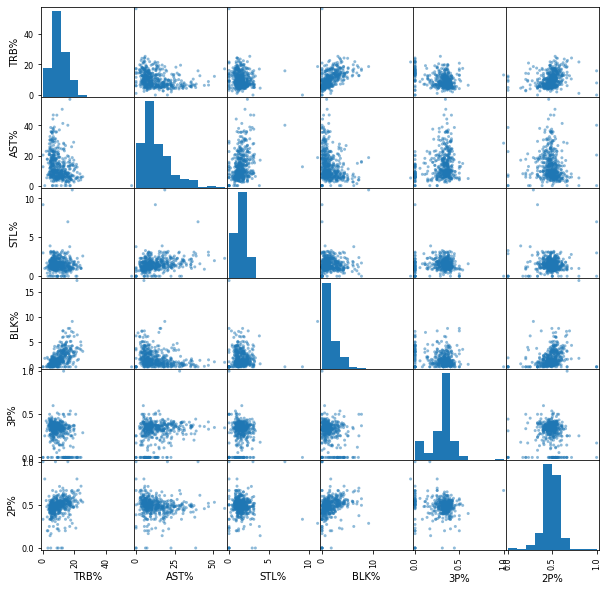

In [0]:
from pandas.plotting import scatter_matrix

scatter_matrix(data[['TRB%','AST%','STL%','BLK%','3P%','2P%']], figsize= (10, 10))

# **PREPARING THE DATA**

In [0]:
#Seperate feature set and target variable
#Pos = Position (PG, SG, PF, SF, C)

X_all = data.drop(['Pos'], 1)
Y_all = data['Pos']

#Standardising the data
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['TRB%', 'AST%', 'STL%', 'BLK%', '3P%', '2P%']]
for col in cols:
  X_all[col] = scale(X_all[col])

In [0]:
#Need continious vars that are integers for input data
#Remove any categorical vars
def preprocess_features(X):
  output = pd.DataFrame(index = X.index)

  for col, col_data in X.iteritems():

    if col_data.dtype == object:
      col_data = pd.get_dummies(col_data, prefix = col)

      #Collect the revised columns
      output = output.join(col_data)

    return output

X_all = preprocess_features(X_all)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 50, random_state = 2, stratify = Y_all)

In [0]:
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))()
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [0]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')

In [0]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='PG')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print (clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [0]:
#DATASET FOR FINDING THE POSITION THE PLAYER IS IN:

#Player (name)
#Pos (Position)
#TS% (True Shooting %)
#3PAr (3-Point Attempt Rate)
#FTr (Free Throw Rate)
#ORB% (Offensive Rebound Percentage)
#DRB% (Defensive Rebound Percentage)
#TRB% (Total Rebound Percentage)
#AST% (Assist Percentage)
#STL% (Steal Percentage)
#BLK% (Block Percentage)
#TOV% (Turnover Percentage)
#USG% (Usage Percentage)
#FG% (Field Goal Percentage)
#3P% (3-Point Field Goal Percentage)
#2P% (2-Point Field Goal Percentage)
#eFG% (Effective Field Goal Percentage)
#FT% (Free Throw Percentage)

#-------------------------------------------------------------------------------------------

#DATASET FOR CALCULATING WIN SHARES, PER, AND OVERALL EFFICIENCY FOR EACH INDIVIDUAL PLAYER:

#Player (name)
#Pos (Position)
#G (Games)
#GS (Games Started)
#MP (Minutes Played)
#PER (Player Efficiency Rating)
#TS% (True Shooting %)
#3PAr (3-Point Attempt Rate)
#FTr (Free Throw Rate)
#ORB% (Offensive Rebound Percentage)
#DRB% (Defensive Rebound Percentage)
#TRB% (Total Rebound Percentage)
#AST% (Assist Percentage)
#STL% (Steal Percentage)
#BLK% (Block Percentage)
#TOV% (Turnover Percentage)
#USG% (Usage Percentage)
#OWS (Offensive Win Shares)
#DWS (Defensive Win Shares)
#WS (Win Shares)
#WS/48 (Win Shares Per 48 Minutes)
#OBPM (Offensive Box Plus/Minus)
#DBPM (Defensive Box Plus/Minus)
#BPM (Box Plus/Minus)
#VORP (Value Over Replacement)
#FG (Field Goals)
#FGA (Field Goal Attempts)
#FG% (Field Goal Percentage)
#3P (3-Point Field Goals)
#3PA (3-Point Field Goal Attempts)
#3P% (3-Point Field Goal Percentage)
#2P (2-Point Field Goals)
#2PA (2-Point Field Goal Attempts)
#2P% (2-Point Field Goal Percentage)
#eFG% (Effective Field Goal Percentage)
#FT (Free Throws)
#FTA (Free Throw Attempts)
#FT% (Free Throw Percentage)
#ORB (Offensive Rebounds)
#DRB (Defensive Rebounds)
#TRB (Total Rebounds)
#AST (Assists)
#STL (Steals)
#BLK (Blocks)
#TOV (Turnovers)
#PF (Personal Fouls)
#PTS (Points)